### dilated conv
ref
https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os   
import cv2
from utils import show_image_mask
import numpy as np
import torch.optim as optim

In [2]:
cmd = '''mkdir ./data
wget -q https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz -O data/MVtech-capsule.tar.xz
tar -Jxf data/MVtech-capsule.tar.xz --overwrite --directory ./data
'''
if not os.path.isdir('./data/capsule'):
    for i in cmd.split('\n'):
        os.system(i)

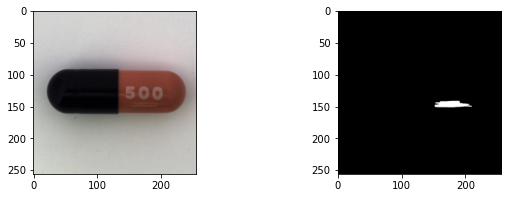

In [3]:
i = '001'
image_ = cv2.imread(f'{os.getcwd()}/data/capsule/test/scratch/{i}.png')
image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)

mask_ = cv2.imread(f'{os.getcwd()}/data/capsule/ground_truth/scratch/{i}_mask.png', cv2.IMREAD_GRAYSCALE)

image_ = cv2.resize(image_, (256, 256), interpolation=cv2.INTER_AREA)
mask_ = cv2.resize(mask_, (256, 256), interpolation=cv2.INTER_AREA)
show_image_mask(image_, mask_)

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


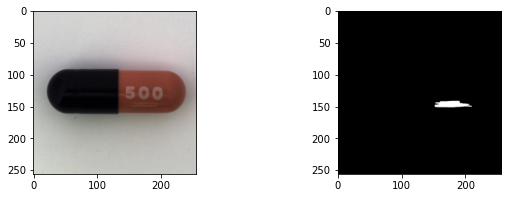

In [44]:
image = torch.Tensor(image_).unsqueeze(0).permute(0,3,1,2)
mask = torch.Tensor(mask_)[...,None,None].permute(2,3,0,1)

print(image.shape)
print(mask.shape)
show_image_mask(image, mask)

In [5]:
x = image
x = nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=1, dilation=(1,1))(x)
x.shape

torch.Size([1, 9, 128, 128])

In [6]:
x = image
x = nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=2, dilation=(2,2))(x)
x.shape

torch.Size([1, 9, 128, 128])

In [7]:
x = image
x = nn.Conv2d(3, 9, kernel_size=3, stride=2, padding=3, dilation=(3,3))(x)
x.shape

torch.Size([1, 9, 128, 128])

In [17]:
class dilated_convBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=2):
        super().__init__()
        self.dilated_rate= [9,9,9]
        self.dilatedConv = lambda rate:nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=rate, dilation=(rate,rate))
        self.relu        = nn.ReLU()
    def forward(self, x):
        tmp = x
        for i in range(len(self.dilated_rate)):
            x = self.dilatedConv(self.dilated_rate[i])(x)
            x = self.relu(x)
        x = x + tmp
#         x = torch.cat([tmp,x], dim=1)
        return x

In [54]:
class SimpleNet(nn.Module):
    def __init__(self, num_class=1, retain_dim=False, out_sz=(256,256)):
        super().__init__()
        self.encoder     = dilated_convBlock(3,3,1)
#         self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(3, num_class, 1)
        
#         self.retain_dim  = retain_dim

    def forward(self, x):
        for i in range(3):
            enc_ftrs = self.encoder(x)
#         print(enc_ftrs.shape)
#         out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:]) # 把不同尺度的所有featuremap都輸入decoder，我們在decoder需要做featuremap的拼接
        out      = self.head(enc_ftrs)
#         print(out.shape)
        
#         if self.retain_dim:
#             out = F.interpolate(out, out_sz)
        return out

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' # for debug建議使用cpu作為torch的運行背景
device

device(type='cuda')

In [56]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

dataset_train = TensorDataset(image.expand(16, 3, 256, 256), mask.expand(16, 1, 256, 256)) 
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True, drop_last=True, 
#                               pin_memory=True
                             )

In [57]:
device = 'cpu'

In [58]:
# x = image
# show_image_mask(x)

net = SimpleNet()
net.to(device)
# net = net
# x = x
# x = net(x)
# x.shape
# show_image_mask(*torch.tensor_split(x, 1, dim=1))

SimpleNet(
  (encoder): dilated_convBlock(
    (relu): ReLU()
  )
  (head): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [60]:
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([1000]).to(device))
optimizer = optim.Adam(net.parameters(), lr = 1e-4)

#  (optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [61]:
for epoch in range(30):  # loop over the dataset multiple times
    torch.cuda.empty_cache()
    running_loss = 0.0
#     sample_i = 0

    
  
    for i, data in enumerate(dataloader_train, 1): # get each batch, setting drop_last
        inputs, mask = data
            
    inputs = inputs.to(device)
    mask = mask.to(device)

#     print(inputs.shape)
#     inputs = inputs.permute(0,3,1,2)
#     mask = mask.unsqueeze(1)
#     mask = mask.float()/255

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
#     print(outputs.shape)
#     print(mask.shape)
    loss = criterion(outputs, mask)
    loss.backward()
    optimizer.step()
    
    # print statistics
    running_loss += loss.item()

#     running_loss = running_loss/len(multiple_inputs)
#     print(f'epochs: {epoch}, average sample loss: {running_loss:.8f}')
    
#     monitor.record()
    
# #     if monitor.record() and running_loss >= best_loss:

# #     print(best_loss, running_loss)
#     if not best_loss:
#         best_loss = running_loss
# #     elif epoch % 100 == 1:
# #         torch.save(model, f'{epoch}_save.pt')
#     elif running_loss < 0.9*best_loss:
#         best_loss = running_loss
#         torch.save(model, 'best_save.pt')
#         monitor.reset()
#         print('save torch model [best_save.pt]')
    

    

    running_loss = 0.0

# torch.save(model, 'last_save.pt')
        
# print('Finished Training')

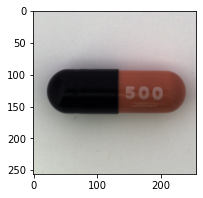

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


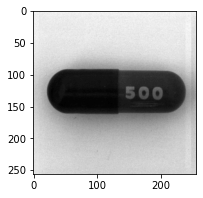

In [64]:
x = image

show_image_mask(x)
print(x.shape)
# for i in range(6):
#     x = dilated_convBlock(3,3,1)(x)
x = net(image)
print(x.shape)

show_image_mask(x)
# show_image_mask(*torch.tensor_split(x, 3, dim=1))


In [ ]:
a = x.flatten(0,2).detach().numpy()
print(a.shape)
plt.imshow(a, cmap='gray')
